# Chapter 6

In [5]:
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import scipy.stats as stats
import numpy as np

## Exercise 1

In [41]:
# Fix this later
mu = [10,20,30]
sd = 1

vals = stats.norm.rvs(loc=mu, scale=sd, size=(100,3)).flatten()
vals[:5]

array([10.23020799, 20.74469592, 30.2285207 ,  9.98915551, 19.97867767])

Let's plot a kde plot to see what things look like

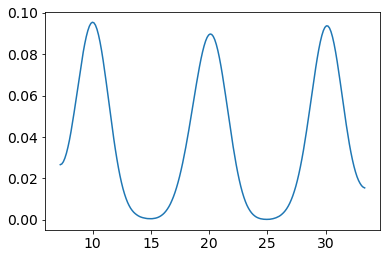

In [42]:
az.plot_kde(vals)

### Fit 2,3 and 4 component mixture models

In [43]:
clusters = [2,3,4]
traces = {}
for cluster in clusters:
    with pm.Model() as two_components:
        p = pm.Dirichlet("p", a=np.ones(cluster))

        # Each mean of the mixture data has its own estimate of a mean with a fixed SD in this case
        means = pm.Normal("means", mu= vals.mean(), sd=10, shape=cluster)
        
        # Estimate of the standard deviation of what?
        sd = pm.HalfCauchy("sd", 1)
        y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=vals)
        
        trace = pm.sample(random_seed=123)
        traces[f"Cluster Size {cluster}"] = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 334.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:09<00:00, 204.37draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:24<00:00, 82.84draws/s]
The acceptance probability does not match the target. It is 0.5858590579621924, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statist

# Exercise 2

In [44]:
comparison = az.compare(traces)
comparison

/Users/canyon/.miniconda3/envs/bap/lib/python3.6/site-packages/arviz/stats/stats.py:863: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,pwaic,dwaic,weight,se,dse,warning
Cluster Size 3,1531.19,6.03058,0,1,27.1171,0,0
Cluster Size 4,1532.2,6.87896,1.0052,1.94289e-16,27.226,0.56753,1
Cluster Size 2,2071.02,3.06129,539.823,0,4.44672,26.5798,0


In [45]:
az.loo(traces["Cluster Size 2"])

,loo,loo_se,p_loo,warning
0,2071.017547,4.446728,3.06112,0


In [38]:
az.loo(traces["Cluster Size 3"])

,loo,loo_se,p_loo,warning
0,-272.217495,22.703903,5.837222,0


In [46]:
az.loo(traces["Cluster Size 4"])

,loo,loo_se,p_loo,warning
0,1532.235529,27.238531,6.896648,0


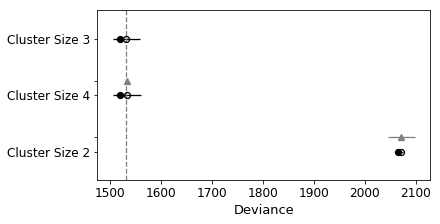

In [47]:
az.plot_compare(comparison)

### Ask about this
When we have four chains why does the MCMC algorithm have so much trouble converging? Is it the starting points and each chain gets stuck in one? 

Alternatively asked why isn't there just an indentifiability problem?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c21902da0>,
      dtype=object)

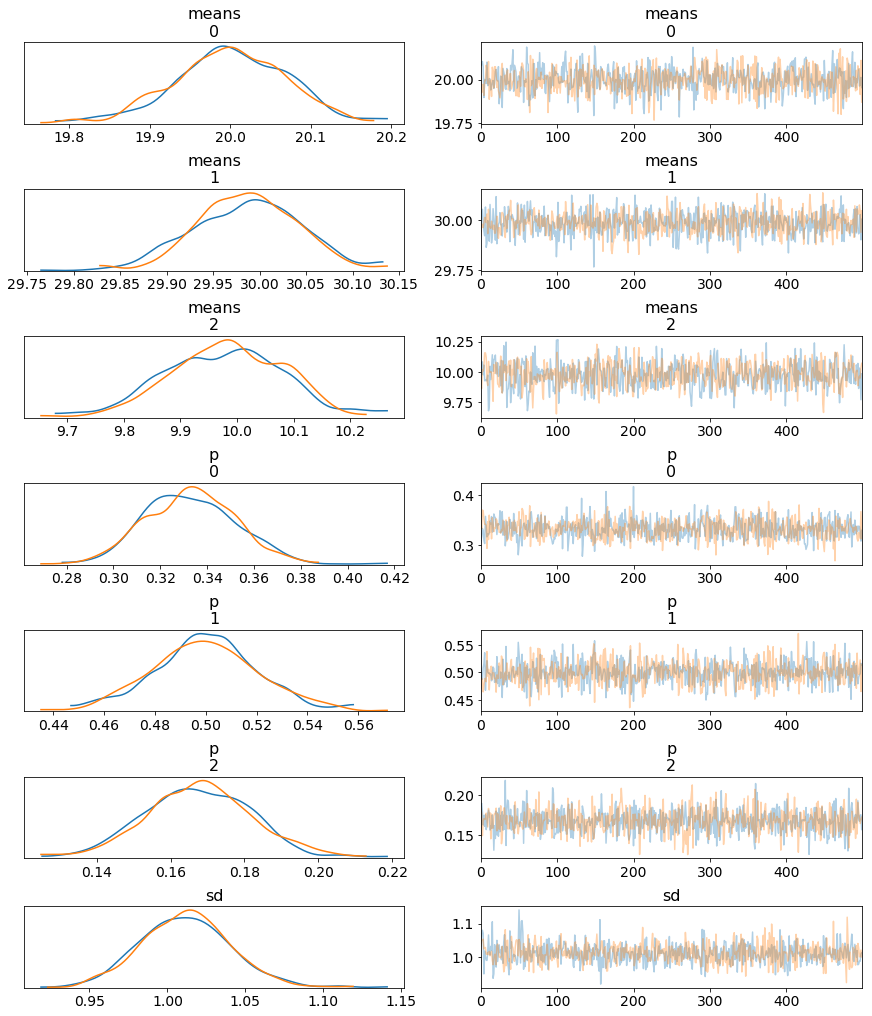

In [24]:
az.plot_trace(traces["Cluster Size 3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e0daa58>,
      dtype=object)

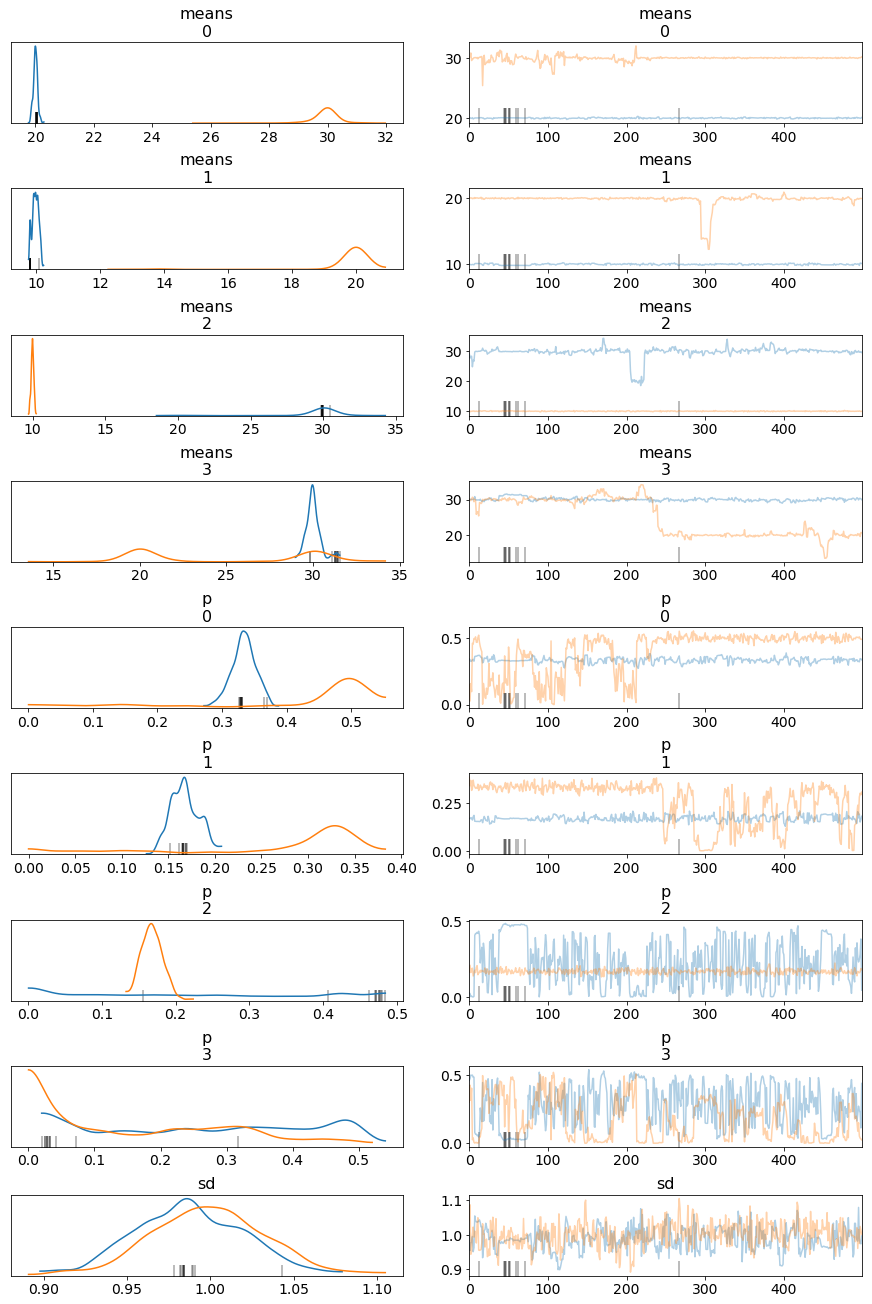

In [23]:
az.plot_trace(traces["Cluster Size 4"])